# 영화 진흥회의 OPEN API를 가져와서 테이블에 저장하기 위한 CSV저장

In [ ]:
from datetime import datetime, timedelta
import requests
import pandas as pd

def get_movie_codes():
    # 초기 데이터 세팅
    api_key = '7a018f527dedab08db78749a2a2fdeca'
    api_url = 'http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json'
    start_date = datetime.now().date() - timedelta(days=365)

    # 1년치 데이터를 모으기 위한 end date 설정 
    end_date = datetime.now().date() - timedelta(days=2)
    # API에 넣을 파라미터
    item_per_page='10'
    multi_movie_yn=None
    rep_nation_cd=None
    wide_area_cd=None

    movie_codes = pd.DataFrame()

    # 영화 상영 정보와 레퍼런스 테이블 생성 
    res = pd.DataFrame()
    target_date = start_date
    
    while target_date <= end_date:
        # API 호출을 위한 파라미터 설정
        params = {
            'key': api_key,
            'targetDt': target_date.strftime('%Y%m%d'),
            'itemPerPage': item_per_page,
            'multiMovieYn': multi_movie_yn,
            'repNationCd': rep_nation_cd,
            'wideAreaCd': wide_area_cd
        }
        try:
            # API 호출
            response = requests.get(api_url, params=params, timeout=60)
            
            # API 호출이 잘 됬으면

            if response.status_code == 200:
                # JSON 데이터 파싱
                print("uploading movie sales data... " + target_date.strftime('%Y%m%d') + " done")
                json_data = response.json()
                print(json_data)
                df = pd.DataFrame(json_data['boxOfficeResult']['dailyBoxOfficeList'])
                df['date'] = target_date.strftime('%Y%m%d')
                res = pd.concat([res, df])

        except Exception as error:
                print("API 호출 중 오류가 발생하였습니다.")
                print(str(error))

        target_date += timedelta(days=1)
        
    res = res.reset_index(drop=True).drop(['rnum'], axis=1)
    date_column = res.pop('date')
    res.insert(0, 'date', date_column)
    res.to_csv('movie_sale.csv', index=False)
    movie_codes= res[['movieNm', 'movieCd']].drop_duplicates()
    movie_codes.to_csv('movie_codes.csv', index=False)
    return movie_codes


def get_movie_details(movie_codes):
    movie_summary = pd.DataFrame()
    movie_genre = pd.DataFrame()
    movie_director = pd.DataFrame()
    movie_company = pd.DataFrame()
    movie_grade = pd.DataFrame()
    # 영화 코드 별 상세 정보 테이블 추출
    api_url = "http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieInfo.json"
    api_key = "7a018f527dedab08db78749a2a2fdeca" 
    index = 1
    for movieCd in movie_codes["movieCd"]:
        print("uploading movie details... " + str(index) + "/" + str(len(movie_codes)) + " done")
        # API 호출
        params = {
            'key': api_key,
            'movieCd': movieCd,
        }
        try:
            # API 호출
            response = requests.get(api_url, params=params, timeout=60)
            if response.status_code == 200:
                # JSON 데이터 파싱
                json_data = response.json()
                df = pd.json_normalize(json_data['movieInfoResult']['movieInfo'])
                
                
                if len(df['actors'][0]) > 0:
                    df_summary = df.explode(['actors'])
                    df_summary['actors'] = df_summary['actors'].apply(lambda x: x['peopleNm'])
                    movie_summary = pd.concat([movie_summary, df_summary[['movieCd', 'movieNm', 'movieNmEn', 'showTm', 'prdtYear', 'openDt', 'actors']]]).drop_duplicates()
        
                if len(df['genres'][0]) > 0:
                    df_genre = df.explode(['genres'])
                    df_genre['genres'] = df_genre['genres'].apply(lambda x: x['genreNm'])
                    movie_genre = pd.concat([movie_genre, df_genre[['movieCd', 'genres']]]).drop_duplicates()

                if len(df['directors'][0]) > 0:
                    df_director = df.explode(['directors'])
                    df_director['directors'] = df_director['directors'].apply(lambda x: x['peopleNm'])
                    movie_director = pd.concat([movie_director, df_director[['movieCd', 'directors']]]).drop_duplicates()

                if len(df['companys'][0]) > 0:
                    df_company = df.explode(['companys'])
                    df_company['companys'] = df_company['companys'].apply(lambda x: x['companyNm'])
                    movie_company = pd.concat([movie_company, df_company[['movieCd', 'companys']]]).drop_duplicates()

                if len(df['audits'][0]) > 0:
                    df_grade = df.explode(['audits'])
                    df_grade['audits'] = df_grade['audits'].apply(lambda x: x['watchGradeNm'])
                    movie_grade = pd.concat([movie_grade, df_grade[['movieCd', 'audits']]]).drop_duplicates()


        except Exception as error:
                print("movieCd: " + movieCd)
                print("API 호출 중 오류가 발생하였습니다.")
                print(str(error))
        index += 1

    movie_summary.to_csv('movie_summary.csv', index=False)
    movie_genre.to_csv('movie_genre.csv', index=False)
    movie_director.to_csv('movie_director.csv', index=False)
    movie_company.to_csv('movie_company.csv', index=False)
    movie_grade.to_csv('movie_grade.csv', index=False)


def run():
    movie_codes = get_movie_codes()
    get_movie_details(movie_codes)
    
def main():
    run()    
    
if __name__ == "__main__":
    main()

# 호출 후 저장되어 있는 데이터 가져오기

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sales = pd.read_csv('movie_sale.csv', encoding='utf-8')
summary = pd.read_csv('movie_summary.csv', encoding='utf-8')
grade = pd.read_csv('movie_grade.csv', encoding='utf-8')
genre = pd.read_csv('movie_genre.csv', encoding='utf-8')
codes = pd.read_csv('movie_codes.csv', encoding='utf-8')
director = pd.read_csv('movie_director.csv', encoding='utf-8')
company = pd.read_csv('movie_company.csv', encoding='utf-8')

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460 entries, 0 to 3459
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3460 non-null   int64  
 1   rank           3460 non-null   int64  
 2   rankInten      3460 non-null   int64  
 3   rankOldAndNew  3460 non-null   object 
 4   movieCd        3460 non-null   int64  
 5   movieNm        3460 non-null   object 
 6   openDt         3460 non-null   object 
 7   salesAmt       3460 non-null   int64  
 8   salesShare     3460 non-null   float64
 9   salesInten     3460 non-null   int64  
 10  salesChange    3460 non-null   float64
 11  salesAcc       3460 non-null   int64  
 12  audiCnt        3460 non-null   int64  
 13  audiInten      3460 non-null   int64  
 14  audiChange     3460 non-null   float64
 15  audiAcc        3460 non-null   int64  
 16  scrnCnt        3460 non-null   int64  
 17  showCnt        3460 non-null   int64  
dtypes: float

In [4]:
# summary 에서 영화 장르 상영시간 가져오기
summary_dedup = summary[['movieCd', 'showTm']].drop_duplicates('movieCd')
sales = sales.merge(summary_dedup, on='movieCd', how='left')

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3460 entries, 0 to 3459
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3460 non-null   int64  
 1   rank           3460 non-null   int64  
 2   rankInten      3460 non-null   int64  
 3   rankOldAndNew  3460 non-null   object 
 4   movieCd        3460 non-null   int64  
 5   movieNm        3460 non-null   object 
 6   openDt         3460 non-null   object 
 7   salesAmt       3460 non-null   int64  
 8   salesShare     3460 non-null   float64
 9   salesInten     3460 non-null   int64  
 10  salesChange    3460 non-null   float64
 11  salesAcc       3460 non-null   int64  
 12  audiCnt        3460 non-null   int64  
 13  audiInten      3460 non-null   int64  
 14  audiChange     3460 non-null   float64
 15  audiAcc        3460 non-null   int64  
 16  scrnCnt        3460 non-null   int64  
 17  showCnt        3460 non-null   int64  
 18  showTm  

In [6]:
# genre 테이블에서 영화 장르 가져오기
summary_dedup = genre[['movieCd', 'genres']].drop_duplicates('movieCd')
sales = sales.merge(summary_dedup, on='movieCd', how='left')

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3460 entries, 0 to 3459
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3460 non-null   int64  
 1   rank           3460 non-null   int64  
 2   rankInten      3460 non-null   int64  
 3   rankOldAndNew  3460 non-null   object 
 4   movieCd        3460 non-null   int64  
 5   movieNm        3460 non-null   object 
 6   openDt         3460 non-null   object 
 7   salesAmt       3460 non-null   int64  
 8   salesShare     3460 non-null   float64
 9   salesInten     3460 non-null   int64  
 10  salesChange    3460 non-null   float64
 11  salesAcc       3460 non-null   int64  
 12  audiCnt        3460 non-null   int64  
 13  audiInten      3460 non-null   int64  
 14  audiChange     3460 non-null   float64
 15  audiAcc        3460 non-null   int64  
 16  scrnCnt        3460 non-null   int64  
 17  showCnt        3460 non-null   int64  
 18  showTm  

In [8]:
summary_dedup = grade[['movieCd', 'audits']].drop_duplicates('movieCd')
sales = sales.merge(summary_dedup, on='movieCd', how='left')

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3460 entries, 0 to 3459
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3460 non-null   int64  
 1   rank           3460 non-null   int64  
 2   rankInten      3460 non-null   int64  
 3   rankOldAndNew  3460 non-null   object 
 4   movieCd        3460 non-null   int64  
 5   movieNm        3460 non-null   object 
 6   openDt         3460 non-null   object 
 7   salesAmt       3460 non-null   int64  
 8   salesShare     3460 non-null   float64
 9   salesInten     3460 non-null   int64  
 10  salesChange    3460 non-null   float64
 11  salesAcc       3460 non-null   int64  
 12  audiCnt        3460 non-null   int64  
 13  audiInten      3460 non-null   int64  
 14  audiChange     3460 non-null   float64
 15  audiAcc        3460 non-null   int64  
 16  scrnCnt        3460 non-null   int64  
 17  showCnt        3460 non-null   int64  
 18  showTm  

In [10]:
sales.dropna(inplace = True)

## Prediction Target으로 사용한 내일 매출액에 해당하는 컬럼 생성

In [11]:
sales['newdate'] = pd.to_datetime(sales['date'], format='%Y%m%d')
sales_sorted = sales.sort_values(by=['movieCd', 'newdate'])
sales_sorted.head(10)

,date,rank,rankInten,rankOldAndNew,movieCd,movieNm,openDt,salesAmt,salesShare,salesInten,...,audiCnt,audiInten,audiChange,audiAcc,scrnCnt,showCnt,showTm,genres,audits,newdate
1045,20220921,6,0,NEW,19528001,사랑은 비를 타고,,26928357,1.3,26928357,...,3053,3053,100.0,11688,33,80,103.0,뮤지컬,전체관람가,2022-09-21
318,20220706,9,23,OLD,19978805,큐어,2022-07-06,14104900,0.2,12561900,...,1437,1326,1194.6,4210,51,73,111.0,공포(호러),15세관람가,2022-07-06
327,20220707,8,1,OLD,19978805,큐어,2022-07-06,14872800,0.4,767900,...,1533,96,6.7,5743,53,90,111.0,공포(호러),15세관람가,2022-07-07
336,20220708,7,1,OLD,19978805,큐어,2022-07-06,16063000,0.3,1190200,...,1544,11,0.7,7287,54,94,111.0,공포(호러),15세관람가,2022-07-08
346,20220709,7,0,OLD,19978805,큐어,2022-07-06,26613700,0.2,10550700,...,2381,837,54.2,9668,55,93,111.0,공포(호러),15세관람가,2022-07-09
356,20220710,7,0,OLD,19978805,큐어,2022-07-06,19030400,0.2,-7583300,...,1774,-607,-25.5,11442,50,86,111.0,공포(호러),15세관람가,2022-07-10
368,20220711,9,-2,OLD,19978805,큐어,2022-07-06,10410100,0.4,-8620300,...,1028,-746,-42.1,12470,49,83,111.0,공포(호러),15세관람가,2022-07-11
377,20220712,8,1,OLD,19978805,큐어,2022-07-06,12910300,0.5,2500200,...,1328,300,29.2,13798,53,90,111.0,공포(호러),15세관람가,2022-07-12
2381,20230210,2,0,OLD,19980074,타이타닉,1998-02-20,471483180,22.9,59021280,...,30550,2167,7.6,530818,385,1074,194.0,드라마,15세 미만인 자는 관람할 수 없는 등급,2023-02-10
2391,20230211,2,0,OLD,19980074,타이타닉,1998-02-20,908895660,22.2,437412480,...,59651,29101,95.3,590469,447,1312,194.0,드라마,15세 미만인 자는 관람할 수 없는 등급,2023-02-11


In [12]:
sales_sorted['tomorrowAmt'] = sales_sorted.groupby('movieCd')['salesAmt'].shift(-1)

In [13]:
sales_sorted.head(10)

,date,rank,rankInten,rankOldAndNew,movieCd,movieNm,openDt,salesAmt,salesShare,salesInten,...,audiInten,audiChange,audiAcc,scrnCnt,showCnt,showTm,genres,audits,newdate,tomorrowAmt
1045,20220921,6,0,NEW,19528001,사랑은 비를 타고,,26928357,1.3,26928357,...,3053,100.0,11688,33,80,103.0,뮤지컬,전체관람가,2022-09-21,NaN
318,20220706,9,23,OLD,19978805,큐어,2022-07-06,14104900,0.2,12561900,...,1326,1194.6,4210,51,73,111.0,공포(호러),15세관람가,2022-07-06,14872800.0
327,20220707,8,1,OLD,19978805,큐어,2022-07-06,14872800,0.4,767900,...,96,6.7,5743,53,90,111.0,공포(호러),15세관람가,2022-07-07,16063000.0
336,20220708,7,1,OLD,19978805,큐어,2022-07-06,16063000,0.3,1190200,...,11,0.7,7287,54,94,111.0,공포(호러),15세관람가,2022-07-08,26613700.0
346,20220709,7,0,OLD,19978805,큐어,2022-07-06,26613700,0.2,10550700,...,837,54.2,9668,55,93,111.0,공포(호러),15세관람가,2022-07-09,19030400.0
356,20220710,7,0,OLD,19978805,큐어,2022-07-06,19030400,0.2,-7583300,...,-607,-25.5,11442,50,86,111.0,공포(호러),15세관람가,2022-07-10,10410100.0
368,20220711,9,-2,OLD,19978805,큐어,2022-07-06,10410100,0.4,-8620300,...,-746,-42.1,12470,49,83,111.0,공포(호러),15세관람가,2022-07-11,12910300.0
377,20220712,8,1,OLD,19978805,큐어,2022-07-06,12910300,0.5,2500200,...,300,29.2,13798,53,90,111.0,공포(호러),15세관람가,2022-07-12,NaN
2381,20230210,2,0,OLD,19980074,타이타닉,1998-02-20,471483180,22.9,59021280,...,2167,7.6,530818,385,1074,194.0,드라마,15세 미만인 자는 관람할 수 없는 등급,2023-02-10,908895660.0
2391,20230211,2,0,OLD,19980074,타이타닉,1998-02-20,908895660,22.2,437412480,...,29101,95.3,590469,447,1312,194.0,드라마,15세 미만인 자는 관람할 수 없는 등급,2023-02-11,935261660.0


In [14]:
sales = sales_sorted
sales.sort_values(by = 'newdate')
sales = sales.dropna()

In [15]:
sales.head(50)

,date,rank,rankInten,rankOldAndNew,movieCd,movieNm,openDt,salesAmt,salesShare,salesInten,...,audiInten,audiChange,audiAcc,scrnCnt,showCnt,showTm,genres,audits,newdate,tomorrowAmt
318,20220706,9,23,OLD,19978805,큐어,2022-07-06,14104900,0.2,12561900,...,1326,1194.6,4210,51,73,111.0,공포(호러),15세관람가,2022-07-06,14872800.0
327,20220707,8,1,OLD,19978805,큐어,2022-07-06,14872800,0.4,767900,...,96,6.7,5743,53,90,111.0,공포(호러),15세관람가,2022-07-07,16063000.0
336,20220708,7,1,OLD,19978805,큐어,2022-07-06,16063000,0.3,1190200,...,11,0.7,7287,54,94,111.0,공포(호러),15세관람가,2022-07-08,26613700.0
346,20220709,7,0,OLD,19978805,큐어,2022-07-06,26613700,0.2,10550700,...,837,54.2,9668,55,93,111.0,공포(호러),15세관람가,2022-07-09,19030400.0
356,20220710,7,0,OLD,19978805,큐어,2022-07-06,19030400,0.2,-7583300,...,-607,-25.5,11442,50,86,111.0,공포(호러),15세관람가,2022-07-10,10410100.0
368,20220711,9,-2,OLD,19978805,큐어,2022-07-06,10410100,0.4,-8620300,...,-746,-42.1,12470,49,83,111.0,공포(호러),15세관람가,2022-07-11,12910300.0
2381,20230210,2,0,OLD,19980074,타이타닉,1998-02-20,471483180,22.9,59021280,...,2167,7.6,530818,385,1074,194.0,드라마,15세 미만인 자는 관람할 수 없는 등급,2023-02-10,908895660.0
2391,20230211,2,0,OLD,19980074,타이타닉,1998-02-20,908895660,22.2,437412480,...,29101,95.3,590469,447,1312,194.0,드라마,15세 미만인 자는 관람할 수 없는 등급,2023-02-11,935261660.0
2401,20230212,2,0,OLD,19980074,타이타닉,1998-02-20,935261660,24.1,26366000,...,3140,5.3,653260,445,1315,194.0,드라마,15세 미만인 자는 관람할 수 없는 등급,2023-02-12,361746980.0
2411,20230213,2,0,OLD,19980074,타이타닉,1998-02-20,361746980,25.8,-573514680,...,-37655,-60.0,678396,423,1204,194.0,드라마,15세 미만인 자는 관람할 수 없는 등급,2023-02-13,440263650.0


In [16]:
sales['newdate2'] = pd.to_datetime(sales['date'].astype(str), format='%Y%m%d')
sales = sales.sort_values(by='newdate2')

/var/folders/_b/ccs2_ysn155d6f3wqkwjbgwh0000gn/T/ipykernel_74054/939611989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['newdate2'] = pd.to_datetime(sales['date'].astype(str), format='%Y%m%d')


In [17]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1 to 3443
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           2748 non-null   int64         
 1   rank           2748 non-null   int64         
 2   rankInten      2748 non-null   int64         
 3   rankOldAndNew  2748 non-null   object        
 4   movieCd        2748 non-null   int64         
 5   movieNm        2748 non-null   object        
 6   openDt         2748 non-null   object        
 7   salesAmt       2748 non-null   int64         
 8   salesShare     2748 non-null   float64       
 9   salesInten     2748 non-null   int64         
 10  salesChange    2748 non-null   float64       
 11  salesAcc       2748 non-null   int64         
 12  audiCnt        2748 non-null   int64         
 13  audiInten      2748 non-null   int64         
 14  audiChange     2748 non-null   float64       
 15  audiAcc        2748 n

In [18]:
sales.drop(['newdate','newdate2'],axis=1, inplace = True)

In [19]:
sales.head(5)

,date,rank,rankInten,rankOldAndNew,movieCd,movieNm,openDt,salesAmt,salesShare,salesInten,...,audiCnt,audiInten,audiChange,audiAcc,scrnCnt,showCnt,showTm,genres,audits,tomorrowAmt
1,20220601,2,-1,OLD,20204548,범죄도시2,2022-05-18,4774754660,32.5,2132052040,...,463146,197801,74.5,7476583,1305,5317,105.0,범죄,15세이상관람가,1.502494e+09
3,20220601,4,-1,OLD,20224634,그대가 조국,2022-05-25,327029180,2.2,157792200,...,40328,23018,133.0,230065,356,402,124.0,다큐멘터리,12세이상관람가,8.891907e+07
2,20220601,3,0,NEW,20135304,극장판 포켓몬스터DP: 기라티나와 하늘의 꽃다발 쉐이미,2022-06-01,1547458980,10.5,1547458980,...,163336,163336,100.0,163336,809,1741,96.0,애니메이션,전체관람가,5.847490e+07
6,20220601,7,0,NEW,20224468,애프터 양,2022-06-01,37465500,0.3,37465500,...,3579,3579,100.0,4754,161,250,95.0,드라마,전체관람가,2.192840e+07
9,20220601,10,-3,OLD,20211568,"아치의 노래, 정태춘",2022-05-18,6031900,0.0,-2183000,...,647,-224,-25.7,24508,25,33,113.0,다큐멘터리,전체관람가,3.773000e+06


In [20]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1 to 3443
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2748 non-null   int64  
 1   rank           2748 non-null   int64  
 2   rankInten      2748 non-null   int64  
 3   rankOldAndNew  2748 non-null   object 
 4   movieCd        2748 non-null   int64  
 5   movieNm        2748 non-null   object 
 6   openDt         2748 non-null   object 
 7   salesAmt       2748 non-null   int64  
 8   salesShare     2748 non-null   float64
 9   salesInten     2748 non-null   int64  
 10  salesChange    2748 non-null   float64
 11  salesAcc       2748 non-null   int64  
 12  audiCnt        2748 non-null   int64  
 13  audiInten      2748 non-null   int64  
 14  audiChange     2748 non-null   float64
 15  audiAcc        2748 non-null   int64  
 16  scrnCnt        2748 non-null   int64  
 17  showCnt        2748 non-null   int64  
 18  showTm  

## 결측치 제거

결측치가 25프로 이상인 Column은 없으므로, 결측치가 있는 row만 제거

In [21]:
sales.dropna(inplace = True)

In [22]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1 to 3443
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2748 non-null   int64  
 1   rank           2748 non-null   int64  
 2   rankInten      2748 non-null   int64  
 3   rankOldAndNew  2748 non-null   object 
 4   movieCd        2748 non-null   int64  
 5   movieNm        2748 non-null   object 
 6   openDt         2748 non-null   object 
 7   salesAmt       2748 non-null   int64  
 8   salesShare     2748 non-null   float64
 9   salesInten     2748 non-null   int64  
 10  salesChange    2748 non-null   float64
 11  salesAcc       2748 non-null   int64  
 12  audiCnt        2748 non-null   int64  
 13  audiInten      2748 non-null   int64  
 14  audiChange     2748 non-null   float64
 15  audiAcc        2748 non-null   int64  
 16  scrnCnt        2748 non-null   int64  
 17  showCnt        2748 non-null   int64  
 18  showTm  

# 수치형 데이터 EDA

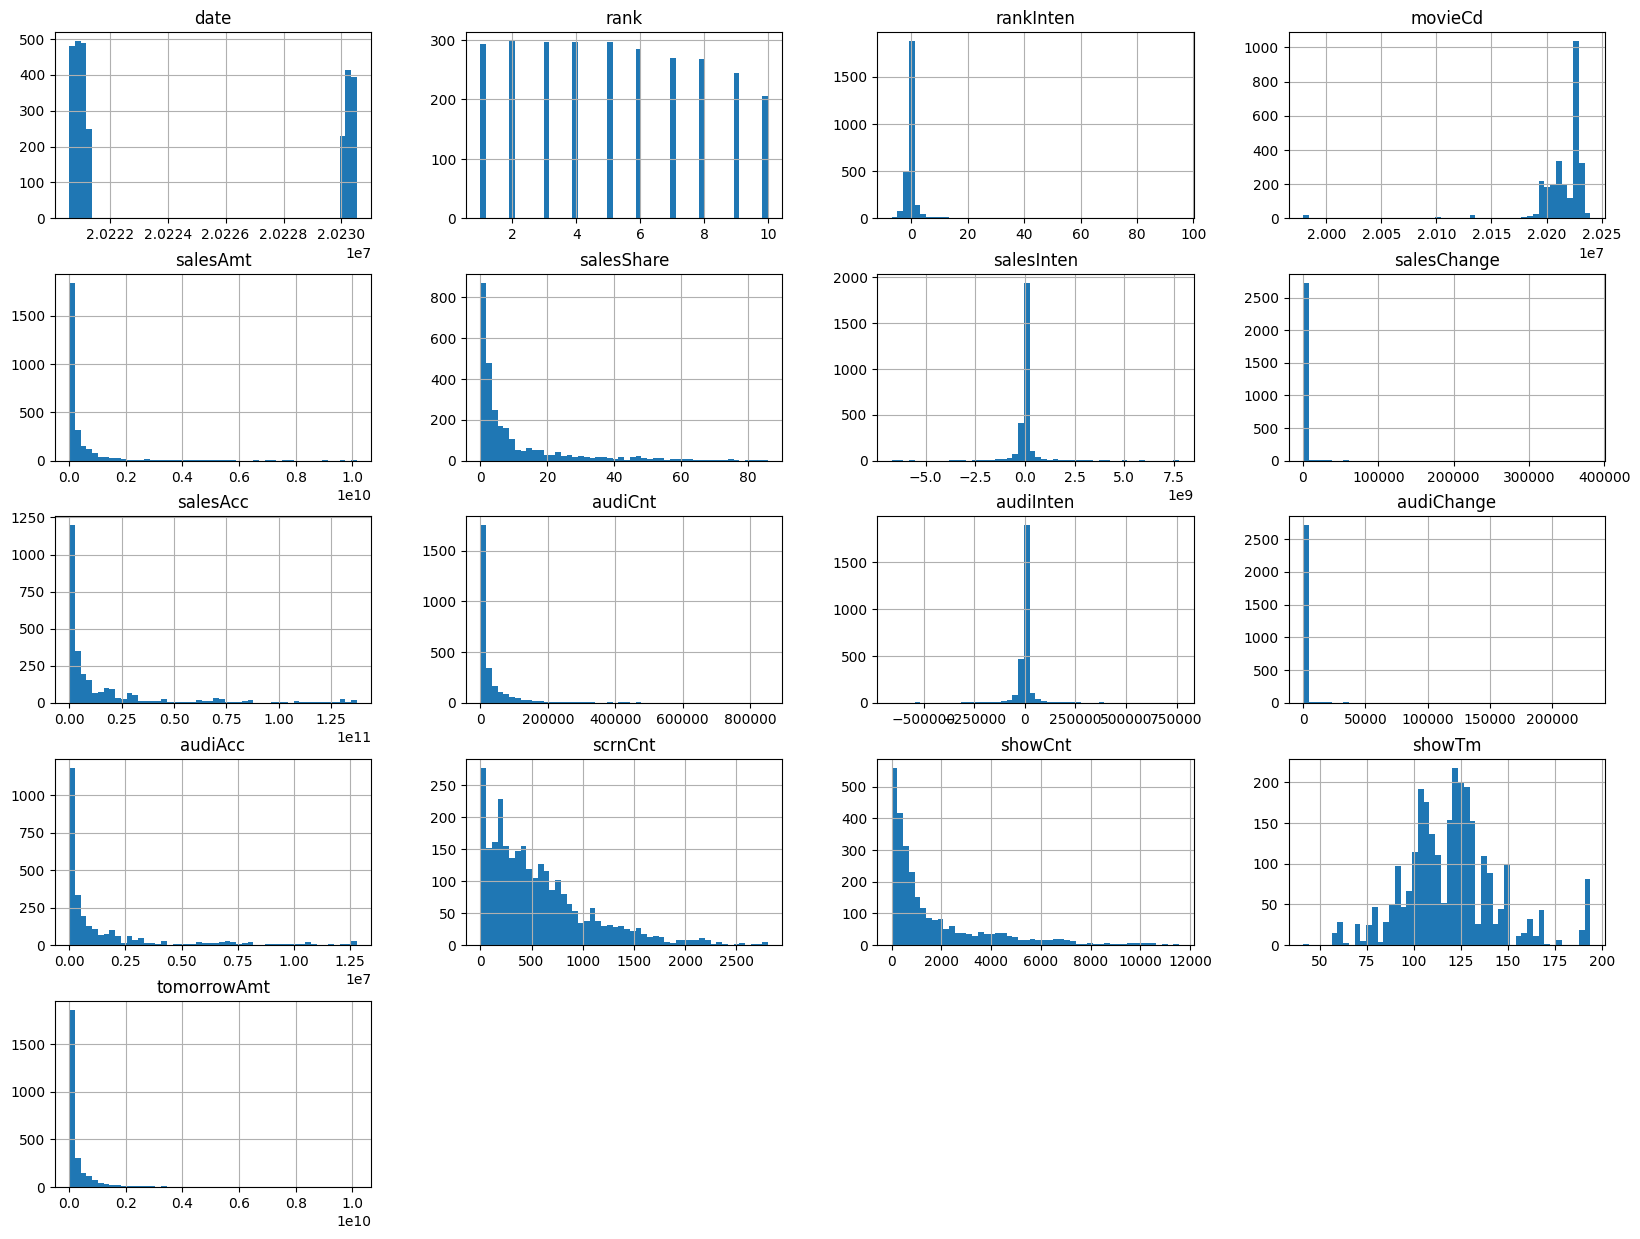

In [23]:
sales.hist(bins =50, figsize = (20,15))
plt.show()

## 수치형 -> 범주형


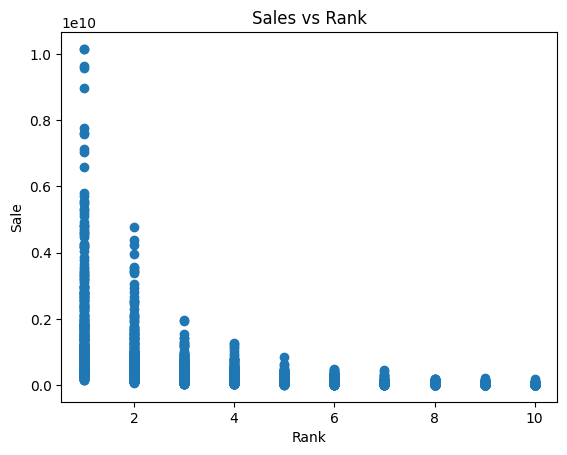

In [24]:

plt.scatter(sales['rank'], sales['salesAmt'])
plt.xlabel('Rank')
plt.ylabel('Sale')
plt.title('Sales vs Rank')
plt.show()


Rank의 경우 순위와 Sale관의 선형 관계보다는 log 관계가 강해서 object type으로 변환하여 해석

In [25]:
sales['rank'] = sales['rank'].astype('object')

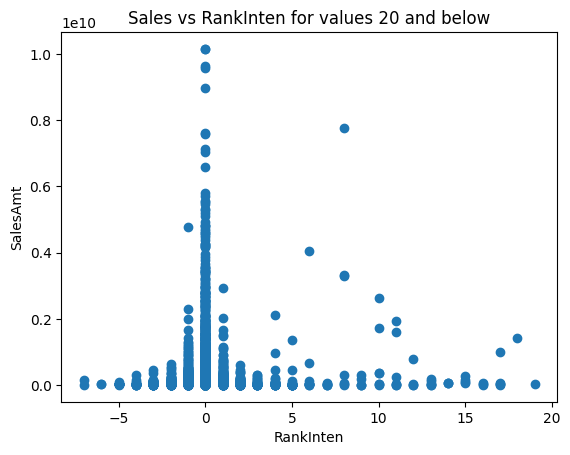

In [26]:
filtered_sales = sales[sales['rankInten'] <= 20]

plt.scatter(filtered_sales['rankInten'], filtered_sales['salesAmt'])
plt.xlabel('RankInten')
plt.ylabel('SalesAmt')
plt.title('Sales vs RankInten for values 20 and below')
plt.show()


In [27]:
sales['rankInten'] = sales['rankInten'].astype('object')

날짜 보다는 시즌(분기)로 object type으로 변환하여 해석하는것이 합당

In [28]:
moviedate = pd.to_datetime(sales['date'].astype(str), format='%Y%m%d')
sales['month'] = moviedate.dt.month
seasons = {1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 
           6: 'summer', 7: 'summer', 8: 'summer', 9: 'fall', 10: 'fall', 
           11: 'fall', 12: 'winter'}
sales['season'] = sales['month'].map(seasons)
sales = sales.drop('month', axis=1)

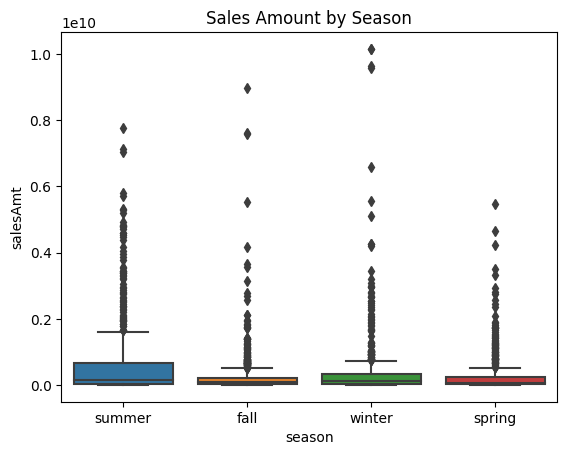

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='season', y='salesAmt', data=sales)
plt.title('Sales Amount by Season')
plt.show()


In [30]:
sales.drop('date',axis=1,inplace = True)

In [31]:
sales.drop('movieCd',axis = 1, inplace = True)
sales.drop('salesInten',axis=1, inplace = True)
sales.drop('audiInten', axis=1 , inplace = True)

In [32]:
sales.drop_duplicates(inplace = True)

In [33]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1 to 3443
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rank           2748 non-null   object 
 1   rankInten      2748 non-null   object 
 2   rankOldAndNew  2748 non-null   object 
 3   movieNm        2748 non-null   object 
 4   openDt         2748 non-null   object 
 5   salesAmt       2748 non-null   int64  
 6   salesShare     2748 non-null   float64
 7   salesChange    2748 non-null   float64
 8   salesAcc       2748 non-null   int64  
 9   audiCnt        2748 non-null   int64  
 10  audiChange     2748 non-null   float64
 11  audiAcc        2748 non-null   int64  
 12  scrnCnt        2748 non-null   int64  
 13  showCnt        2748 non-null   int64  
 14  showTm         2748 non-null   float64
 15  genres         2748 non-null   object 
 16  audits         2748 non-null   object 
 17  tomorrowAmt    2748 non-null   float64
 18  season  

## 수치형 변수 이상치제거 및 Covariance

In [34]:
df = sales.select_dtypes(exclude = 'object')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1 to 3443
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salesAmt     2748 non-null   int64  
 1   salesShare   2748 non-null   float64
 2   salesChange  2748 non-null   float64
 3   salesAcc     2748 non-null   int64  
 4   audiCnt      2748 non-null   int64  
 5   audiChange   2748 non-null   float64
 6   audiAcc      2748 non-null   int64  
 7   scrnCnt      2748 non-null   int64  
 8   showCnt      2748 non-null   int64  
 9   showTm       2748 non-null   float64
 10  tomorrowAmt  2748 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 257.6 KB


Covariance 분석을 위해선 이상치가 없어야 해서 적용

In [36]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


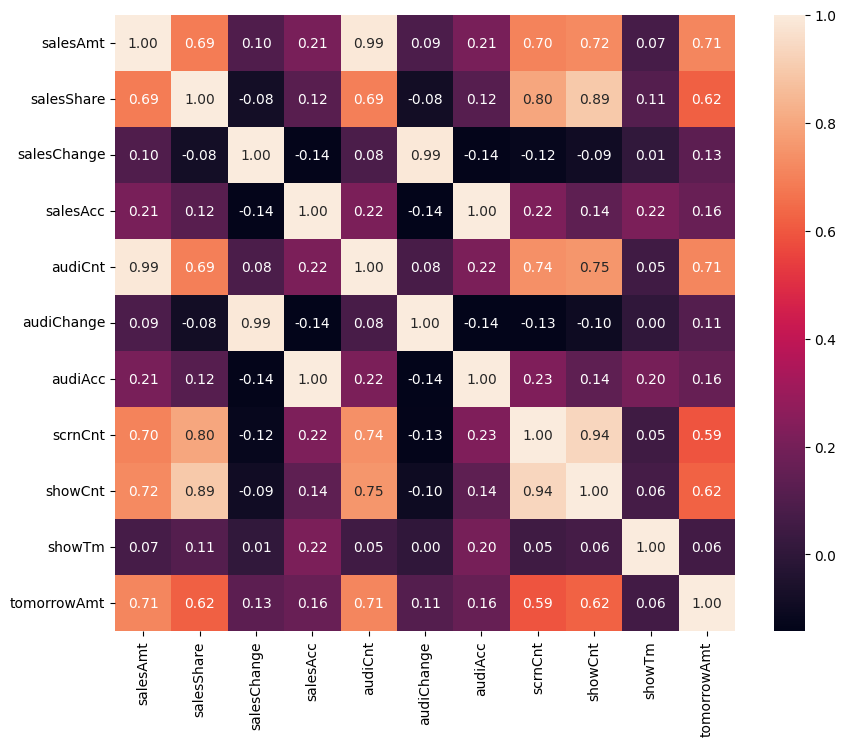

In [37]:
corr_matrix = df_out.corr()
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", annot_kws={"size": 10})  # Set font size
plt.show()

In [38]:
sales.drop(['audiCnt','showCnt','audiChange'],axis=1, inplace = True)


In [39]:
sales.drop(['audiAcc'],axis=1,inplace = True)

In [40]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1 to 3443
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rank           2748 non-null   object 
 1   rankInten      2748 non-null   object 
 2   rankOldAndNew  2748 non-null   object 
 3   movieNm        2748 non-null   object 
 4   openDt         2748 non-null   object 
 5   salesAmt       2748 non-null   int64  
 6   salesShare     2748 non-null   float64
 7   salesChange    2748 non-null   float64
 8   salesAcc       2748 non-null   int64  
 9   scrnCnt        2748 non-null   int64  
 10  showTm         2748 non-null   float64
 11  genres         2748 non-null   object 
 12  audits         2748 non-null   object 
 13  tomorrowAmt    2748 non-null   float64
 14  season         2748 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 343.5+ KB


# Object Type 데이터 처리

salesShare 가 랭킹과 같은 의미이고, salesChange가 RankInten 과 같은 의미이므로 해당 범주형 변수를 제거함

In [41]:
sales.drop(['rank','rankInten'],axis=1 ,inplace = True)

영화 코드는 단순 아이디이므로 제거, openDt는 상영일자나 시즌과 겹침으로 제거

In [42]:
sales.drop(['movieNm','openDt'],axis=1 ,inplace = True)

In [43]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1 to 3443
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rankOldAndNew  2748 non-null   object 
 1   salesAmt       2748 non-null   int64  
 2   salesShare     2748 non-null   float64
 3   salesChange    2748 non-null   float64
 4   salesAcc       2748 non-null   int64  
 5   scrnCnt        2748 non-null   int64  
 6   showTm         2748 non-null   float64
 7   genres         2748 non-null   object 
 8   audits         2748 non-null   object 
 9   tomorrowAmt    2748 non-null   float64
 10  season         2748 non-null   object 
dtypes: float64(4), int64(3), object(4)
memory usage: 257.6+ KB


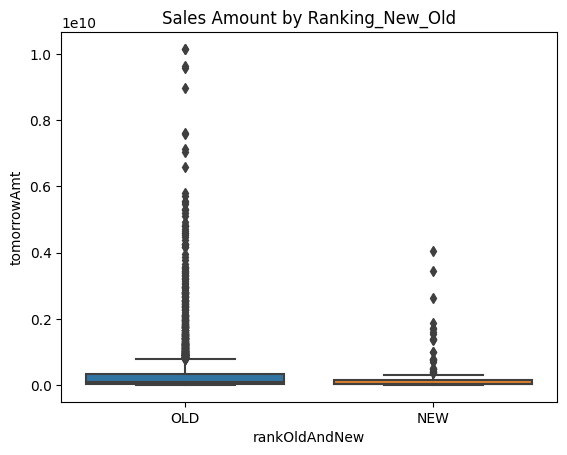

In [44]:
sns.boxplot(x='rankOldAndNew', y='tomorrowAmt', data=sales)
plt.title('Sales Amount by Ranking_New_Old')
plt.show()


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51396 (\N{HANGUL SYLLABLE JOE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **k

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48036 (\N{HANGUL SYLLABLE MYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52972 (\N{HANGUL SYLLABLE KEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'NanumGo

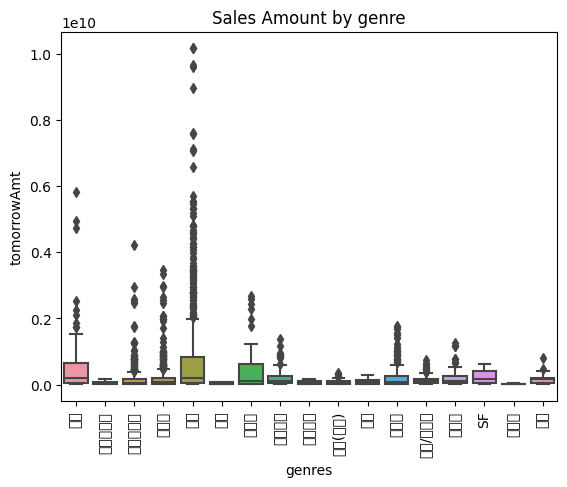

In [45]:
plt.rcParams['font.family'] = 'NanumGothic'

sns.boxplot(x='genres', y='tomorrowAmt', data=sales)
plt.title('Sales Amount by genre')
plt.xticks(rotation='vertical')
plt.show()

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/

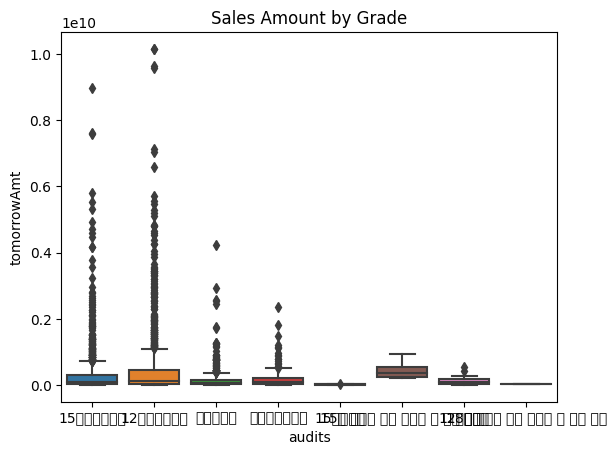

In [46]:

sns.boxplot(x='audits', y='tomorrowAmt', data=sales)
plt.title('Sales Amount by Grade')
plt.show()

## 원핫인코딩

In [47]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 1 to 3443
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rankOldAndNew  2748 non-null   object 
 1   salesAmt       2748 non-null   int64  
 2   salesShare     2748 non-null   float64
 3   salesChange    2748 non-null   float64
 4   salesAcc       2748 non-null   int64  
 5   scrnCnt        2748 non-null   int64  
 6   showTm         2748 non-null   float64
 7   genres         2748 non-null   object 
 8   audits         2748 non-null   object 
 9   tomorrowAmt    2748 non-null   float64
 10  season         2748 non-null   object 
dtypes: float64(4), int64(3), object(4)
memory usage: 257.6+ KB


In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [49]:
X = sales.drop('tomorrowAmt', axis=1)
y = sales['tomorrowAmt']

In [50]:
numeric_features = ['salesAmt', 'salesShare', 'salesChange', 'salesAcc', 'scrnCnt', 'showTm']
categorical_features = ['rankOldAndNew', 'genres', 'audits', 'season']

In [51]:
X_num = X[numeric_features]
X_cat = X[categorical_features]

## 정규화

In [52]:
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)

## 원핫인코딩

In [53]:
encoder = OneHotEncoder(drop='first')
X_cat_encoded = encoder.fit_transform(X_cat).toarray()

# Getting the names of one-hot encoded columns
encoded_features = list(encoder.get_feature_names_out(categorical_features))
X_cat_encoded = pd.DataFrame(X_cat_encoded, columns=encoded_features)


In [54]:
X_cat_encoded.head(5)

,rankOldAndNew_OLD,genres_가족,genres_공연,genres_공포(호러),genres_기타,genres_다큐멘터리,genres_드라마,genres_멜로/로맨스,genres_뮤지컬,genres_미스터리,...,audits_12세이상관람가,audits_15세 미만인 자는 관람할 수 없는 등급,audits_15세관람가,audits_15세이상관람가,audits_18세 미만인 자는 관람할 수 없는 등급,audits_전체관람가,audits_청소년관람불가,season_spring,season_summer,season_winter
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [55]:
X_processed = pd.concat([X_num_scaled, X_cat_encoded], axis=1)

In [56]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   salesAmt                        2748 non-null   float64
 1   salesShare                      2748 non-null   float64
 2   salesChange                     2748 non-null   float64
 3   salesAcc                        2748 non-null   float64
 4   scrnCnt                         2748 non-null   float64
 5   showTm                          2748 non-null   float64
 6   rankOldAndNew_OLD               2748 non-null   float64
 7   genres_가족                       2748 non-null   float64
 8   genres_공연                       2748 non-null   float64
 9   genres_공포(호러)                   2748 non-null   float64
 10  genres_기타                       2748 non-null   float64
 11  genres_다큐멘터리                    2748 non-null   float64
 12  genres_드라마                      27

## Train / Test Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

## Feature Extraction (UMAP)

In [71]:
from umap import UMAP

In [76]:
umap = UMAP(n_neighbors=30, min_dist=0.1,n_components=10, random_state=42)

In [77]:
X_train_transformed = umap.fit_transform(X_train)

In [78]:
X_test_transformed = umap.transform(X_test)

In [80]:
X_train_transformed.shape

(2198, 10)

# Lasso 

In [81]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

## Lasso 파라미터 찾기

In [82]:
from sklearn.linear_model import LassoCV

# Define the alphas range you want to explore for LassoCV
alphas = np.logspace(-10, 10, 200)

# Initialize LassoCV with 5-fold cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)

# Fit the model to the training data
lasso_cv.fit(X_train, y_train)

# Access the optimal alpha value
optimal_alpha = lasso_cv.alpha_

print("Optimal alpha:", optimal_alpha)


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0876482514756305e+19, tolerance: 1.2650469800442549e+17
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7404884504022155e+19, tolerance: 1.2650469800442549e+17
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9755639027227754e+19, tolerance: 1.2650469800442549e+17
  model = cd_fast.enet_coordinate_descen

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.959192150489737e+19, tolerance: 1.1582842019050901e+17
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4839742602810917e+19, tolerance: 1.1582842019050901e+17
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.9858749756072624e+19, tolerance: 1.1582842019050901e+17
  model = cd_fast.enet_coordinate_descent

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.49906194569448e+20, tolerance: 1.1394986610043224e+17
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.700436385934816e+19, tolerance: 1.1394986610043224e+17
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5507916264658856e+20, tolerance: 1.1394986610043224e+17
  model = cd_fast.enet_coordinate_descent_g

Optimal alpha: 15343684.089300131


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6122214931941953e+20, tolerance: 1.0198310869236714e+17
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6308462909190328e+20, tolerance: 1.0198310869236714e+17
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6262307549918455e+20, tolerance: 1.0198310869236714e+17
  model = cd_fast.enet_coordinate_descen

## Lasso Regression

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


Mean Squared Error: 3.601044949384374e+17
R^2 Score: 0.6854263544065513


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

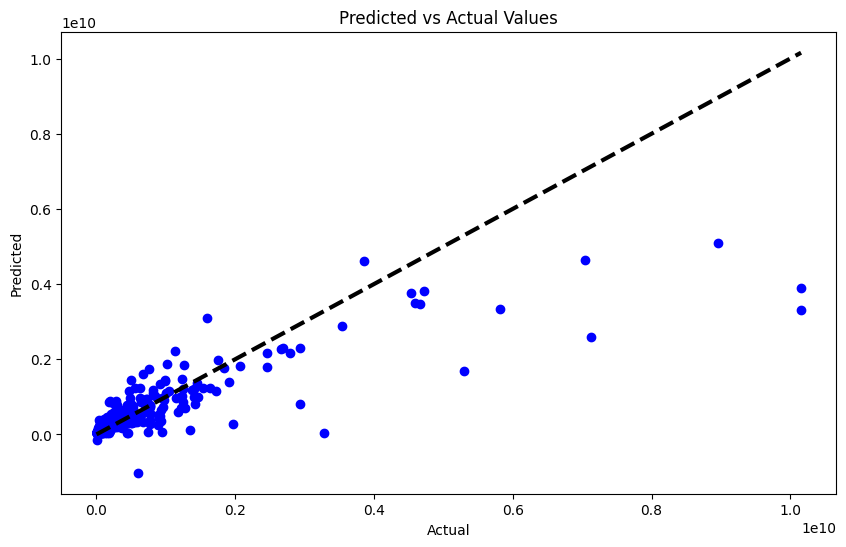

Adjusted R^2 Score:  0.6653082724209238


In [83]:
lasso = Lasso(alpha=optimal_alpha)

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Plotting predicted vs actual values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Values')
plt.show()

# Computing Adjusted R^2
n = X_test.shape[0]
k = X_test.shape[1]
r2 = r2_score(y_test, y_pred)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print("Adjusted R^2 Score: ", adjusted_r2)



# Ridge

## Ridge Parameter 찾기

In [85]:
from sklearn.linear_model import RidgeCV

# Define the alphas range you want to explore for RidgeCV
alphas = np.logspace(-10, 10, 200)

# Initialize RidgeCV with 5-fold cross-validation
ridge_cv = RidgeCV(alphas=alphas, cv=5)   

# Fit the model to the training data
ridge_cv.fit(X_train, y_train)

# Access the optimal alpha value
optimal_alpha = ridge_cv.alpha_

print("Optimal alpha:", optimal_alpha)


Optimal alpha: 182.51834943190462


## Ridge Regression

In [86]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

ridge_model = Ridge(alpha=optimal_alpha)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
n = X_test.shape[0]
k = X_test.shape[1]
r2 = r2_score(y_test, y_pred)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print("Adjusted R^2 Score: ", adjusted_r2)


Mean Squared Error: 3.9217343867720006e+17
R^2 Score: 0.6574121399659391
Adjusted R^2 Score:  0.6355024512428304


# RandomForest

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

## RF 파라미터 찾기

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # the number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # the maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # the minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # the minimum number of samples required to be at a leaf node
}

# Initialize a RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)


Best parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


## RF Regression

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


Mean Squared Error: 2.08759151170761e+17
R^2 Score: 0.8176359135811205
Adjusted R^2 Score:  0.8059730941008434


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

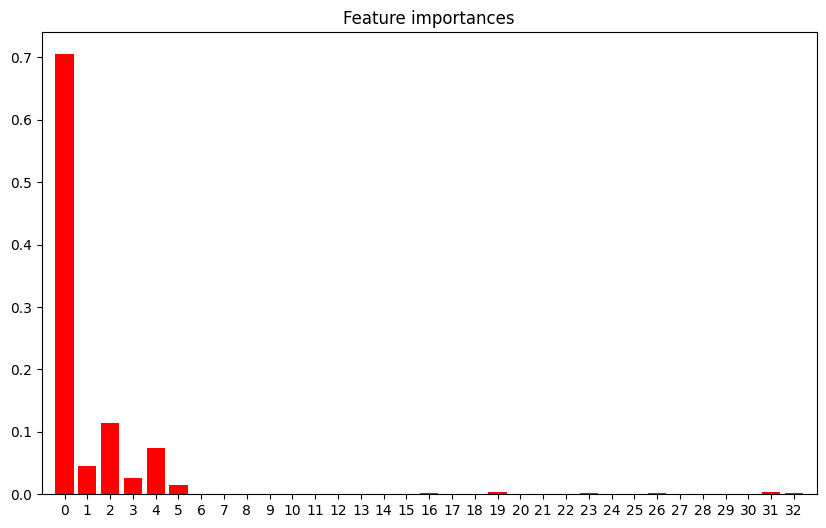

In [89]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Create a new RandomForestRegressor with the optimal parameters
rf_best = RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42)

# Fit the model to the training data
rf_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_best.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

n = X_test.shape[0]
k = X_test.shape[1]
r2 = r2_score(y_test, y_pred)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print("Adjusted R^2 Score: ", adjusted_r2)
# Get feature importances
importances = rf_best.feature_importances_

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances, color="r", align="center")
plt.xticks(range(X_train.shape[1]))
plt.xlim([-1, X_train.shape[1]])
plt.show()


# LightGBM

## LightGBM 파라미터 찾기

In [91]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # the number of boosting stages
    'max_depth': [None, 10, 20, 30],       # the maximum depth of the trees
    'num_leaves': [31, 61, 81, 101],       # the maximum number of leaves for base learners
    'learning_rate': [0.1, 0.01, 0.001],   # the learning rate
}

# Initialize an LGBMRegressor
lgbm = LGBMRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)


Best parameters:  {'learning_rate': 0.01, 'max_depth': 30, 'n_estimators': 400, 'num_leaves': 61}


## LightGBM regression

In [92]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Create a new LGBMRegressor with the optimal parameters
lgbm_best = LGBMRegressor(**best_params, random_state=42)

# Fit the model to the training data
lgbm_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lgbm_best.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

n = X_test.shape[0]
k = X_test.shape[1]
r2 = r2_score(y_test, y_pred)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print("Adjusted R^2 Score: ", adjusted_r2)


Mean Squared Error: 2.5588392839374368e+17
R^2 Score: 0.776469493341498
Adjusted R^2 Score:  0.7621739376831054


# XGBoost

## XGBoost 파라미터 찾기

In [93]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # the number of boosting stages
    'max_depth': [None, 10, 20, 30],       # the maximum depth of the trees
    'learning_rate': [0.1, 0.01, 0.001],   # the learning rate
}

# Initialize an XGBRegressor
xgb = XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)


Best parameters:  {'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 300}


## XGBoost Regression

In [94]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time

# Create a new XGBRegressor with the optimal parameters
xgb_best = XGBRegressor(**best_params, random_state=42)

start = time.time()
# Fit the model to the training data
xgb_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_best.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
end = time.time()
print(end-start)
n = X_test.shape[0]
k = X_test.shape[1]
r2 = r2_score(y_test, y_pred)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print("Adjusted R^2 Score: ", adjusted_r2)

Mean Squared Error: 2.0438965222665062e+17
R^2 Score: 0.8214529423369001
8.746677875518799
Adjusted R^2 Score:  0.8100342351607717


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47708 (\N{HANGUL SYLLABLE MEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47592 (\N{HANGUL SYLLABLE MAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'NanumGo

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found

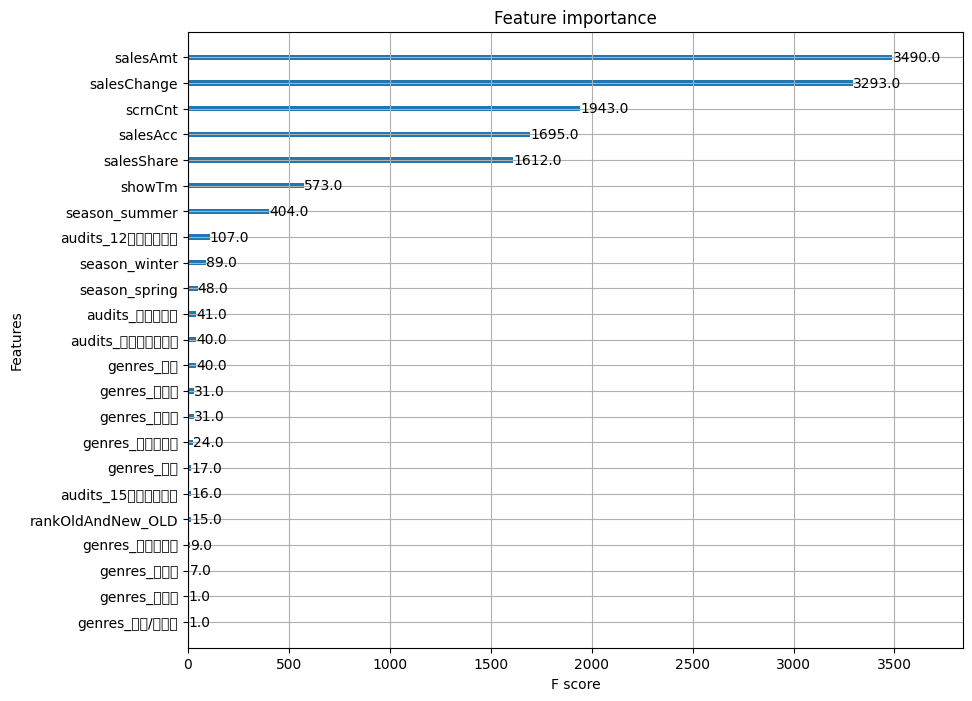

In [95]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_best, ax=ax)
plt.show()